### Example 7: Flat-sky fields

This sample script showcases the flat-sky version of pymaster.

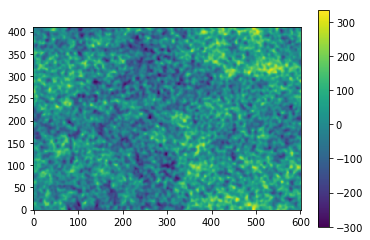

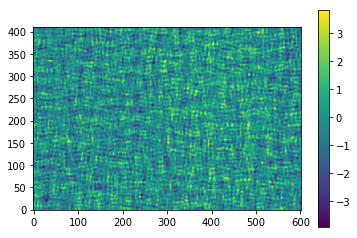

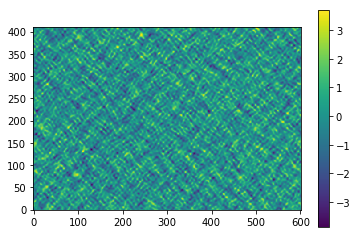

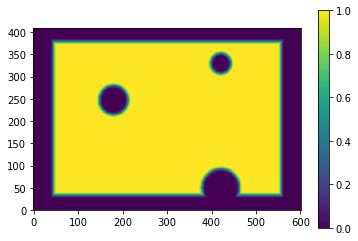

In [ ]:
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as plt


# This script describes the functionality of the flat-sky version of pymaster

# Dimensions:
# First, a flat-sky field is defined by four quantities:
#  - Lx and Ly: the size of the patch in the x and y dimensions (in radians)
Lx = 72. * np.pi/180
Ly = 48. * np.pi/180
#  - Nx and Ny: the number of pixels in the x and y dimensions
Nx = 602
Ny = 410

# Gaussian simulations:
# pymaster allows you to generate random realizations of both spherical and
# flat fields given a power spectrum. These are returned as 2D arrays with
# shape (Ny,Nx)
l, cl_tt, cl_ee, cl_bb, cl_te = np.loadtxt('cls.txt', unpack=True)
beam = np.exp(-(0.25 * np.pi/180 * l)**2)
cl_tt *= beam
cl_ee *= beam
cl_bb *= beam
cl_te *= beam
mpt, mpq, mpu = nmt.synfast_flat(Nx, Ny, Lx, Ly,
                                 np.array([cl_tt, cl_te, 0 * cl_tt,
                                           cl_ee, 0 * cl_ee, cl_bb]),
                                 [0, 2])

# You can have a look at the maps using matplotlib's imshow:
plt.figure()
plt.imshow(mpt, interpolation='nearest', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mpq, interpolation='nearest', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mpu, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

# Masks:
# Let's now create a mask:
mask = np.ones_like(mpt).flatten()
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny


# First we dig a couple of holes
def dig_hole(x, y, r):
    rad = (np.sqrt((xarr - x)**2 + (yarr - y)**2)).flatten()
    return np.where(rad < r)[0]


mask[dig_hole(0.3 * Lx, 0.6 * Ly, 0.05 * np.sqrt(Lx * Ly))] = 0.
mask[dig_hole(0.7 * Lx, 0.12 * Ly, 0.07 * np.sqrt(Lx * Ly))] = 0.
mask[dig_hole(0.7 * Lx, 0.8 * Ly, 0.03 * np.sqrt(Lx * Ly))] = 0.
# Let's also trim the edges
mask[np.where(xarr.flatten() < Lx / 16.)] = 0
mask[np.where(xarr.flatten() > 15 * Lx / 16.)] = 0
mask[np.where(yarr.flatten() < Ly / 16.)] = 0
mask[np.where(yarr.flatten() > 15 * Ly / 16.)] = 0
mask = mask.reshape([Ny, Nx])
# You can also apodize it in the same way you do for full-sky masks:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=2., apotype="C1")
plt.figure()
plt.imshow(mask, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

# Fields:
# Once you have maps it's time to create pymaster fields.
# Note that, as in the full-sky case, you can also pass
# contaminant templates and flags for E and B purification
# (see the documentation for more details)
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [mpt])
f2 = nmt.NmtFieldFlat(Lx, Ly, mask, [mpq, mpu], purify_b=True)

# Bins:
# For flat-sky fields, bandpowers are simply defined as intervals in ell, and
# pymaster doesn't currently support any weighting scheme within each interval.
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, lf_bins)
# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

# Workspaces:
# As in the full-sky case, the computation of the coupling matrix and of
# the pseudo-CL estimator is mediated by a WorkspaceFlat case, initialized
# by calling its compute_coupling_matrix method:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)
w02 = nmt.NmtWorkspaceFlat()
w02.compute_coupling_matrix(f0, f2, b)
w22 = nmt.NmtWorkspaceFlat()
w22.compute_coupling_matrix(f2, f2, b)
# Workspaces can be saved to and read from disk to avoid recomputing them:
w00.write_to("w00_flat.fits")
w00.read_from("w00_flat.fits")
w02.write_to("w02_flat.fits")
w02.read_from("w02_flat.fits")
w22.write_to("w22_flat.fits")
w22.read_from("w22_flat.fits")

# Computing power spectra:
# As in the full-sky case, you compute the pseudo-CL estimator by
# computing the coupled power spectra and then decoupling them by
# inverting the mode-coupling matrix. This is done in two steps below,
# but pymaster provides convenience routines to do this
# through a single function call
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)
cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2, b)
cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
cl22_uncoupled = w22.decouple_cell(cl22_coupled)

# Let's look at the results!
plt.figure()
plt.plot(l, cl_tt, 'r-', label='Input TT')
plt.plot(l, cl_ee, 'g-', label='Input EE')
plt.plot(l, cl_bb, 'b-', label='Input BB')
plt.plot(ells_uncoupled, cl00_uncoupled[0], 'r--', label='Uncoupled')
plt.plot(ells_uncoupled, cl22_uncoupled[0], 'g--')
plt.plot(ells_uncoupled, cl22_uncoupled[3], 'b--')
plt.loglog()
plt.show();